In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path
import os
import time
from PIL import Image

import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet50

In [6]:
data_dir = os.path.join(Path.cwd().parent, "data")

IMAGE_SIZE = 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [7]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224, scale=(0.85, 1.15)),
    transforms.RandomAffine(0, shear=15, translate=(0.2, 0.2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [8]:
def load_images(df, transform):
    images = []
    labels = []

    for _, row in df.iterrows():
        img = Image.open(row["image"]).convert("RGB")
        img = transform(img)
        label = row["label_idx"]
        images.append(img)
        labels.append(label)

    return torch.stack(images), torch.tensor(labels)

In [9]:
df_train = pd.read_csv(data_dir + "\\train_clean_csv.csv")
df_test = pd.read_csv(data_dir + "\\test_clean_csv.csv")
df_val = pd.read_csv(data_dir + "\\val_clean_csv.csv")

In [10]:
train_imgs, train_labels = load_images(df_train, train_transforms)
test_imgs, test_labels = load_images(df_test, val_test_transforms)
val_imgs, val_labels = load_images(df_val, val_test_transforms)

c:\Users\Jashan Shah\GitHub\FruitVegetableClassifier\venv\Lib\site-packages\PIL\Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [11]:
print(f"train: {train_imgs.shape}, {train_labels.shape}")
print(f"test: {test_imgs.shape}, {test_labels.shape}")
print(f"val: {val_imgs.shape}, {val_labels.shape}")

train: torch.Size([3115, 3, 224, 224]), torch.Size([3115])
test: torch.Size([359, 3, 224, 224]), torch.Size([359])
val: torch.Size([351, 3, 224, 224]), torch.Size([351])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


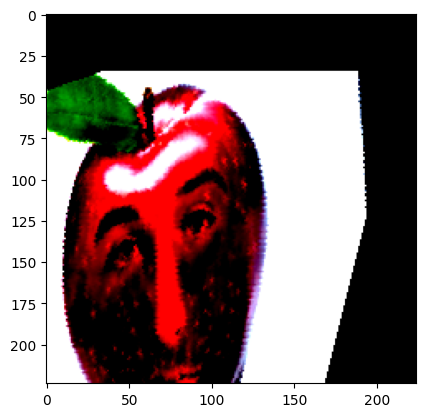

In [12]:
plt.imshow(train_imgs[4].permute(1, 2, 0).numpy())

In [13]:
train_dataset = TensorDataset(train_imgs, train_labels)
test_dataset = TensorDataset(test_imgs, test_labels)
val_dataset = TensorDataset(val_imgs, val_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [14]:
base_model = resnet50(pretrained=True)

c:\Users\Jashan Shah\GitHub\FruitVegetableClassifier\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Jashan Shah\GitHub\FruitVegetableClassifier\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
num_ftrs = base_model.fc.in_features
num_ftrs

2048

In [16]:
for param in base_model.parameters():
    param.requires_grad = False

unfreeze = False

for name, param in base_model.named_parameters():
    if "layer4" in name:
        unfreeze = True
    if unfreeze:
        param.requires_grad = True

In [17]:
base_model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 36)
)

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, base_model.parameters()), lr=0.000001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3, min_lr=0.000001)

In [19]:
best_val_loss = np.inf
patience = 10
counter = 0
num_epochs = 100
device = "cpu"

In [9]:
# base_model.to(device)

# for epoch in range(num_epochs):
#     base_model.train()
#     train_losses = []
#     for img, label in train_loader:
#         img, label = img.to(device), label.to(device)
#         optimizer.zero_grad()
#         output = base_model(img)
#         loss = criterion(output, label)
#         loss.backward()
#         optimizer.step()
#         train_losses.append(loss.item())

#     base_model.eval()
#     val_losses = []
#     preds, targets = [], []
#     with torch.no_grad():
#         for img, label in val_loader:
#             img, label = img.to(device), label.to(device)
#             output = base_model(img)
#             loss = criterion(output, label)
#             val_losses.append(loss.item())
#             pred_labels = torch.argmax(output, dim=1)
#             preds.extend(pred_labels.cpu().numpy())
#             targets.extend(label.cpu().numpy())

#     val_loss = np.mean(val_losses)
#     print(f"Epoch {epoch+1}: Train Loss = {np.mean(train_losses):.4f}, Val Loss = {val_loss:.4f}")
#     scheduler.step(val_loss)

#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         torch.save(base_model.state_dict(), "BestResNet50Model.pth")
#         counter = 0
#     else:
#         counter += 1
#         if counter >= patience:
#             print("Early stopping.")
#             break